# November 17th, 2021

**Motivation**: Figures for Thursday meeting (Nov 18th). <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
from scipy.ndimage import gaussian_filter

def show_h(proj_h, proj_hr, cmap='icefire', interp='antialiased'):
    fig, axes = create_figure(1, 4, (13., 3), gridspec_kw={'width_ratios': [1.8, 1, 1, 1.8]})

    x2plt = proj_h['parcel2d-flat'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[0].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[0], shrink=0.4)

    x2plt = proj_h['parcel2d-top'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[1].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['parcel2d-top'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[2].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['parcel2d-flat'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[3].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[3], shrink=0.4)

    remove_ticks(axes)
    plt.show()
    
    
def get_h(pi_arr, approach='pi_animals'):
    if approach == 'pi_animals':
        pi = bn.nanmean(pi_arr, -3)
        pi = bn.nanmean(bn.nanmean(pi, 2), 1)
        h = sp_stats.entropy(pi, axis=-2) / np.log(pi.shape[-2])
        h = bn.nanmean(h, 0)
        hr = sp_stats.rankdata(h)
    elif approach == 'avg_pi_first':
        pi = bn.nanmean(pi_arr, -3)
        pi = bn.nanmean(bn.nanmean(bn.nanmean(pi, 2), 1), 0)
        h = sp_stats.entropy(pi, axis=0) / np.log(len(pi))
        hr = sp_stats.rankdata(h)
    elif approach == 'no_pi_avg':
        h_arr = sp_stats.entropy(pi_arr, axis=-2) / np.log(pi_arr.shape[-2])
        h = bn.nanmean(h_arr, -3)
        h = bn.nanmean(bn.nanmean(bn.nanmean(h, 2), 1), 0)
    hr = sp_stats.rankdata(h)
    proj_h = gr.project_vec(h)
    proj_hr = gr.project_vec(hr)
    return h, hr, proj_h, proj_hr

In [5]:
mice = Mice((100, 3))
mice.setup_func_data('rest')

In [6]:
props_base = {
    'num_k': 5,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'prepare_data': False,
    'verbose': False,
}
props_ca = {'perc': 'p10-sample', **props_base}
props_bold = {'perc': 'p20-sample', **props_base}

## Get group results

In [10]:
gr = Group(mode='ca2', centroids_from='all', **props_ca)
group_ca = gr.fit_group(skip_align=False)

gr = Group(mode='bold-lite', centroids_from='all', **props_bold)
group_bold = gr.fit_group(skip_align=False)

In [11]:
bins = np.linspace(0.2, 1.0, 5)

statistic = mk_statistic_fn(
    bins=bins,
    est_sub=bn.nanmean,
    est_ses=bn.nanmean,
    est_run=bn.nanmean,
    est_seed=bn.nanmedian,
    scipy=False,
)

In [12]:
output_ca = statistic(group_ca['gam_run'])
output_bold = statistic(group_bold['gam_run'])

In [13]:
list(output_ca)

['pi_anim', 'cut_anim', 'pi_group', 'cut_group']

<matplotlib.colorbar.Colorbar object at 0x7f96d0dd0340>

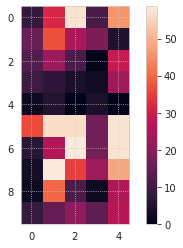

In [14]:
plt.imshow(output_ca['cut_anim'][..., -1])
plt.colorbar()

In [15]:
df = pd.DataFrame(dict(enumerate(output_ca['cut_anim'][..., -1]))).stack().reset_index()
df.head()

,level_0,level_1,0
0,0,0,8.333333
1,0,1,15.909091
2,0,2,12.820513
3,0,3,9.433962
4,0,4,2.127660


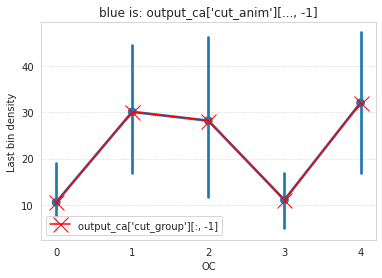

In [16]:
sns.pointplot(data=df, x='level_0', y=0, ci=99)
plt.plot(output_ca['cut_group'][:, -1], color='red', marker='x',
         markersize=15, label="output_ca['cut_group'][:, -1]")
plt.xlabel('OC')
plt.ylabel('Last bin density')
plt.legend()
plt.title('blue is: ' + "output_ca['cut_anim'][..., -1]")
plt.show()

In [13]:
output_ca['cut_group'][:, -1]

array([56.57572891, 29.02859648,  8.62266753])

In [14]:
bad_ids = []

for key in mice.ca:
    sub, ses, run = mice.looper[key]
    if run != -1 or sub == -1 or ses == -1:
        continue

    for run_i in range(4):
        a = group_ca['gam_run'][sub - 1, ses - 1, run_i]
        ratio = np.isnan(a).sum() / np.prod(a.shape)
        if ratio > 0.5:
            bad_ids.append((sub - 1, ses - 1, run_i))
            # print(sub, ses, ' ++ ', run_i, '   ', ratio)

bad_ids

[(1, 1, 3), (7, 0, 3)]

In [15]:
bad_seed_ids = []

for key in mice.ca:
    sub, ses, run = mice.looper[key]
    if run != -1 or sub == -1 or ses == -1:
        continue

    for run_i in range(4):
        for seed_i in range(500):
            a = group_ca['gam_run'][sub - 1, ses - 1, run_i, seed_i]
            ratio = np.isnan(a).sum() / np.prod(a.shape)
            if ratio > 0.5:
                # print(sub, ses, ' ++ ', run_i, seed_i, '   ', ratio)
                bad_seed_ids.append((sub - 1, ses - 1, run_i, seed_i))

bad_seed_ids

[
    (1, 1, 3, 0),
    (1, 1, 3, 1),
    (1, 1, 3, 2),
    (1, 1, 3, 3),
    (1, 1, 3, 4),
    (1, 1, 3, 5),
    (1, 1, 3, 6),
    (1, 1, 3, 7),
    (1, 1, 3, 8),
    (1, 1, 3, 9),
    (1, 1, 3, 10),
    (1, 1, 3, 11),
    (1, 1, 3, 12),
    (1, 1, 3, 13),
    (1, 1, 3, 14),
    (1, 1, 3, 15),
    (1, 1, 3, 16),
    (1, 1, 3, 17),
    (1, 1, 3, 18),
    (1, 1, 3, 19),
    (1, 1, 3, 20),
    (1, 1, 3, 21),
    (1, 1, 3, 22),
    (1, 1, 3, 23),
    (1, 1, 3, 24),
    (1, 1, 3, 25),
    (1, 1, 3, 26),
    (1, 1, 3, 27),
    (1, 1, 3, 28),
    (1, 1, 3, 29),
    (1, 1, 3, 30),
    (1, 1, 3, 31),
    (1, 1, 3, 32),
    (1, 1, 3, 33),
    (1, 1, 3, 34),
    (1, 1, 3, 35),
    (1, 1, 3, 36),
    (1, 1, 3, 37),
    (1, 1, 3, 38),
    (1, 1, 3, 39),
    (1, 1, 3, 40),
    (1, 1, 3, 41),
    (1, 1, 3, 42),
    (1, 1, 3, 43),
    (1, 1, 3, 44),
    (1, 1, 3, 45),
    (1, 1, 3, 46),
    (1, 1, 3, 47),
    (1, 1, 3, 48),
    (1, 1, 3, 49),
    (1, 1, 3, 50),
    (1, 1, 3, 51),
    (1, 1, 3, 52),
    (1, 1, 3, 53),
    (1, 1, 3, 54),
    (1, 1, 3, 55),
    (1, 1, 3, 56),
    (1, 1, 3, 57),
    (1, 1, 3, 58),
    (1, 1, 3, 59),
    (1, 1, 3, 60),
    (1, 1, 3, 61),
    (1, 1, 3, 62),
    (1, 1, 3, 63),
    (1, 1, 3, 64),
    (1, 1, 3, 65),
    (1, 1, 3, 66),
    (1, 1, 3, 67),
    (1, 1, 3, 68),
    (1, 1, 3, 69),
    (1, 1, 3, 70),
    (1, 1, 3, 71),
    (1, 1, 3, 72),
    (1, 1, 3, 73),
    (1, 1, 3, 74),
    (1, 1, 3, 75),
    (1, 1, 3, 76),
    (1, 1, 3, 77),
    (1, 1, 3, 78),
    (1, 1, 3, 79),
    (1, 1, 3, 80),
    (1, 1, 3, 81),
    (1, 1, 3, 82),
    (1, 1, 3, 83),
    (1, 1, 3, 84),
    (1, 1, 3, 85),
    (1, 1, 3, 86),
    (1, 1, 3, 87),
    (1, 1, 3, 88),
    (1, 1, 3, 89),
    (1, 1, 3, 90),
    (1, 1, 3, 91),
    (1, 1, 3, 92),
    (1, 1, 3, 93),
    (1, 1, 3, 94),
    (1, 1, 3, 95),
    (1, 1, 3, 96),
    (1, 1, 3, 97),
    (1, 1, 3, 98),
    (1, 1, 3, 99),
    (1, 1, 3, 100),
    (1, 1, 3, 101),
    (1, 1, 3, 102),
    (1, 1, 3, 103),
    (1, 1, 3, 104),
    (1, 1, 3, 105),
    (1, 1, 3, 106),
    (1, 1, 3, 107),
    (1, 1, 3, 108),
    (1, 1, 3, 109),
    (1, 1, 3, 110),
    (1, 1, 3, 111),
    (1, 1, 3, 112),
    (1, 1, 3, 113),
    (1, 1, 3, 114),
    (1, 1, 3, 115),
    (1, 1, 3, 116),
    (1, 1, 3, 117),
    (1, 1, 3, 118),
    (1, 1, 3, 119),
    (1, 1, 3, 120),
    (1, 1, 3, 121),
    (1, 1, 3, 122),
    (1, 1, 3, 123),
    (1, 1, 3, 124),
    (1, 1, 3, 125),
    (1, 1, 3, 126),
    (1, 1, 3, 127),
    (1, 1, 3, 128),
    (1, 1, 3, 129),
    (1, 1, 3, 130),
    (1, 1, 3, 131),
    (1, 1, 3, 132),
    (1, 1, 3, 133),
    (1, 1, 3, 134),
    (1, 1, 3, 135),
    (1, 1, 3, 136),
    (1, 1, 3, 137),
    (1, 1, 3, 138),
    (1, 1, 3, 139),
    (1, 1, 3, 140),
    (1, 1, 3, 141),
    (1, 1, 3, 142),
    (1, 1, 3, 143),
    (1, 1, 3, 144),
    (1, 1, 3, 145),
    (1, 1, 3, 146),
    (1, 1, 3, 147),
    (1, 1, 3, 148),
    (1, 1, 3, 149),
    (1, 1, 3, 150),
    (1, 1, 3, 151),
    (1, 1, 3, 152),
    (1, 1, 3, 153),
    (1, 1, 3, 154),
    (1, 1, 3, 155),
    (1, 1, 3, 156),
    (1, 1, 3, 157),
    (1, 1, 3, 158),
    (1, 1, 3, 159),
    (1, 1, 3, 160),
    (1, 1, 3, 161),
    (1, 1, 3, 162),
    (1, 1, 3, 163),
    (1, 1, 3, 164),
    (1, 1, 3, 165),
    (1, 1, 3, 166),
    (1, 1, 3, 167),
    (1, 1, 3, 168),
    (1, 1, 3, 169),
    (1, 1, 3, 170),
    (1, 1, 3, 171),
    (1, 1, 3, 172),
    (1, 1, 3, 173),
    (1, 1, 3, 174),
    (1, 1, 3, 175),
    (1, 1, 3, 176),
    (1, 1, 3, 177),
    (1, 1, 3, 178),
    (1, 1, 3, 179),
    (1, 1, 3, 180),
    (1, 1, 3, 181),
    (1, 1, 3, 182),
    (1, 1, 3, 183),
    (1, 1, 3, 184),
    (1, 1, 3, 185),
    (1, 1, 3, 186),
    (1, 1, 3, 187),
    (1, 1, 3, 188),
    (1, 1, 3, 189),
    (1, 1, 3, 190),
    (1, 1, 3, 191),
    (1, 1, 3, 192),
    (1, 1, 3, 193),
    (1, 1, 3, 194),
    (1, 1, 3, 195),
    (1, 1, 3, 196),
    (1, 1, 3, 197),
    (1, 1, 3, 198),
    (1, 1, 3, 199),
    (1, 1, 3, 200),
    (

In [16]:
len(bad_seed_ids)

1000

In [17]:
data_all = []

for key in mice.ca:
    sub, ses, run = mice.looper[key]
    if run != -1 or sub == -1 or ses == -1:
        continue

    for run_i in range(4):
        cond_run = (sub - 1, ses - 1, run_i) in bad_ids
        for seed_i in range(500):
            cond_seed = (sub - 1, ses - 1, run_i, seed_i) in bad_seed_ids
            if not (cond_run or cond_seed):
                a = group_ca['gam_run'][sub - 1, ses - 1, run_i, seed_i]
                data_all.append(a)

data_all = np.concatenate(data_all)
data_all.shape

(171000, 98)

<AxesSubplot:ylabel='Count'>

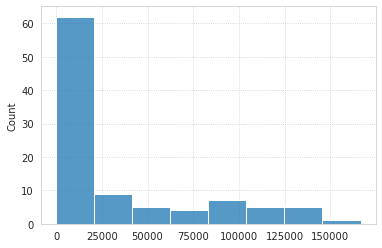

In [22]:
sns.histplot(np.isnan(data_all).sum(0))

In [23]:
np.isnan(data_all).sum(0)

array([106500,  93000,  97500,  51000,   1500, 106500,   1500,      0,
       136500,   3000,      0,      0,   4500,      0, 126000,  21000,
            0,      0,      0, 133500,  99000,      0,      0,      0,
            0,   1500,   6000,  52500,      0,      0,      0,      0,
         1500,  27000,      0,   3000,      0,      0,      0, 120000,
            0,  25500,   1500,  18000,   4500,  46500,  24000,  52500,
       166500, 103500,  79500,  88500,  40500,   6000,  88500,   4500,
         3000, 133500,   7500,      0,      0,      0,      0, 100500,
         9000,      0,      0,      0, 106500,  67500,      0,      0,
            0,      0,      0,  18000,  22500,      0,      0,      0,
            0,   1500,  34500,      0,   3000,      0,      0,      0,
       124500,      0,  30000,   4500,  24000,   6000,  63000,  46500,
        72000, 142500])

In [24]:
nonan = np.where(np.isnan(data_all).sum(0) < 100000)[0]

In [29]:
data_all[np.isnan(data_all)] = 0.

In [30]:
centroids = np_nans((3, data_all.shape[-1]))
_centroids, _ = fit_kmeans(
    data=data_all[:, nonan],
    n_clusters=3,
    match_metric='euclidean',
    random_state=mice.cfg.random_state,
)
centroids[:, nonan] = _centroids
centroids.shape

(3, 98)

In [31]:
centroids /= np.nansum(centroids, 0, keepdims=True)
_disj = gr.get_disjoint_community(centroids, to_vec=True)
aaa = np.concatenate([centroids, np.expand_dims(_disj, 0)])
proj_aaa = gr.project_vec(aaa)

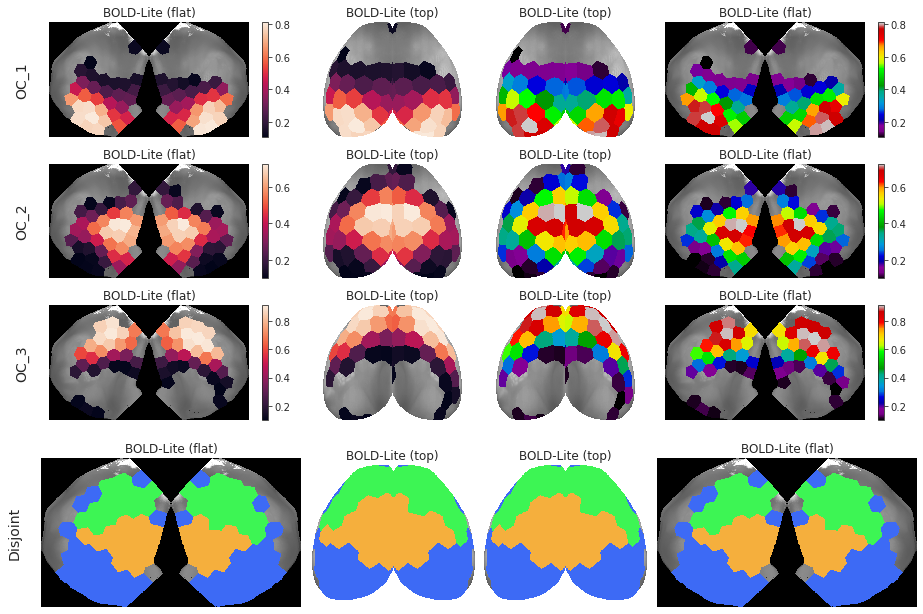

In [32]:
_ = gr.show(proj_aaa)

In [33]:
i = 5
j = 2
kk = 3

a = group_ca['gam_run'][i, j, kk]
a.shape

(500, 3, 98)

In [34]:
ner = Normalizer()

In [35]:
nonan_local = np.where(np.isnan(a).sum(0).sum(0) == 0)[0]
nonan_local

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55,
       56, 58, 59, 60, 61, 62, 64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94,
       95, 96])

In [36]:
a[..., nonan_local].shape, centroids[..., nonan_local].shape

((500, 3, 87), (3, 87))

In [37]:
np.isnan(a[..., nonan_local]).sum(), np.isnan(centroids[..., nonan_local]).sum()

(0, 12)

In [38]:
nonan_consencus = set(nonan).intersection(nonan_local)
nonan_consencus = np.array(sorted(nonan_consencus))
nonan_consencus

array([ 1,  3,  4,  6,  7,  9, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40,
       41, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60,
       61, 62, 64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
       81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96])

In [39]:
np.isnan(a[..., nonan_consencus]).sum(), np.isnan(centroids[..., nonan_consencus]).sum()

(0, 0)

In [40]:
a_normed = np.zeros_like(a)

for i in range(500):
    a_normed[i][:, nonan_consencus] = ner.fit_transform(a[i][:, nonan_consencus])

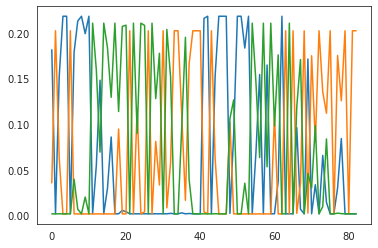

In [41]:
plt.plot(a_normed[54][:, nonan_consencus].T);

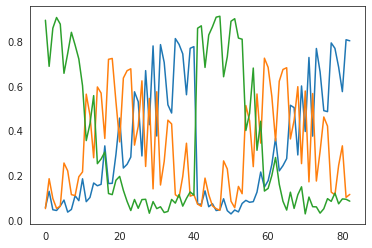

In [42]:
plt.plot(centroids[:, nonan_consencus].T);

In [44]:
dists = np.zeros((500, 3, 3))
dists_mean = np.zeros(500)
for seed_i in range(500):
    d = sp_dist.cdist(
        XA=centroids[:, nonan_consencus],
        XB=a_normed[seed_i][:, nonan_consencus],
        metric='euclidean',
    )
    dists[seed_i] = d
    dists_mean[seed_i] = np.diag(d).mean()

[<matplotlib.lines.Line2D object at 0x7ff39e443550>]

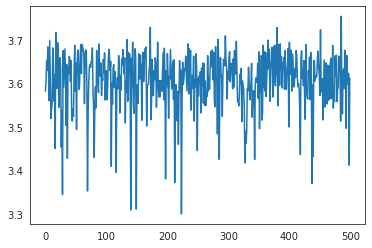

In [45]:
plt.plot(dists_mean)

<AxesSubplot:ylabel='Count'>

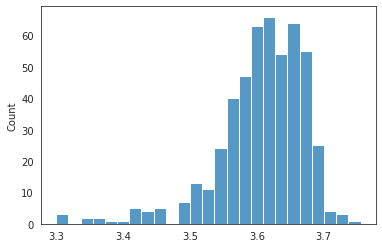

In [46]:
sns.histplot(dists_mean)

In [47]:
dists_cos = np.zeros((500, 3, 3))
dists_mean_cos = np.zeros(500)
for seed_i in range(500):
    d = sp_dist.cdist(
        XA=centroids[:, nonan_consencus],
        XB=a_normed[seed_i][:, nonan_consencus],
        metric='cosine',
    )
    dists_cos[seed_i] = d
    dists_mean_cos[seed_i] = np.diag(d).mean()

<AxesSubplot:ylabel='Count'>

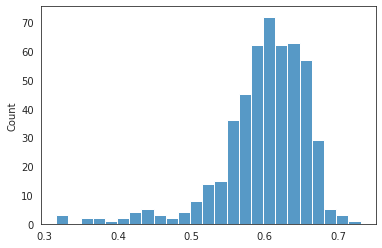

In [48]:
sns.histplot(dists_mean_cos)

<matplotlib.collections.PathCollection object at 0x7ff39d369d60>

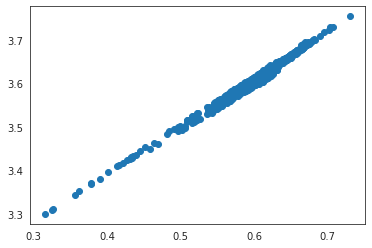

In [49]:
plt.scatter(x=dists_mean_cos, y=dists_mean)

In [50]:
_disj = gr.get_disjoint_community(output_ca['pi_group'], to_vec=True)
pi_avg_with_disj_ca = np.concatenate([output_ca['pi_group'], np.expand_dims(_disj, 0)])
proj_ca = gr.project_vec(pi_avg_with_disj_ca)

_disj = gr.get_disjoint_community(output_bold['pi_group'], to_vec=True)
pi_avg_with_disj_bold = np.concatenate([output_bold['pi_group'], np.expand_dims(_disj, 0)])
proj_bold = gr.project_vec(pi_avg_with_disj_bold)

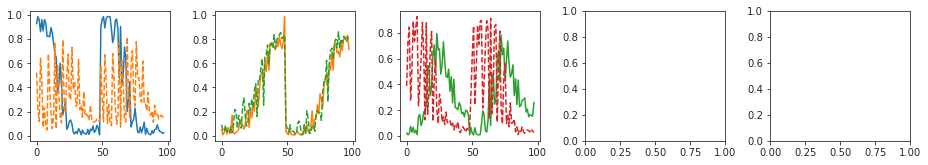

In [51]:
fig, axes = create_figure(1, 5, (13, 2.4))

for i, ax in enumerate(axes.flat):
    try:
        ax.plot(output_ca['pi_group'][i], color=f'C{i}')
        ax.plot(output_bold['pi_group'][i], color=f'C{i+1}', ls='--')
    except IndexError:
        continue
plt.show()

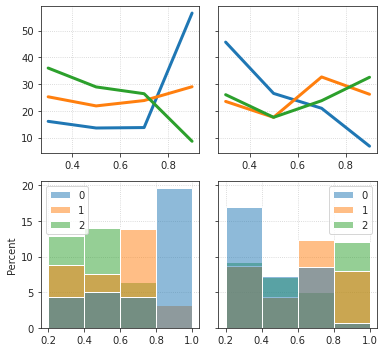

In [52]:
fig, axes = create_figure(2, 2, (5.5, 5), sharey='row')

axes[0, 0].plot((bins[:-1] + bins[1:]) / 2, output_ca['cut_group'].T, lw=3)
axes[0, 1].plot((bins[:-1] + bins[1:]) / 2, output_bold['cut_group'].T, lw=3)

sns.histplot(output_ca['pi_group'].T, bins=bins, stat='percent', ax=axes[1, 0])
sns.histplot(output_bold['pi_group'].T, bins=bins, stat='percent', ax=axes[1, 1])

for ax in axes.flat:
    ax.grid()

plt.show()

In [53]:
statistic_scipy = mk_statistic_fn(
    bins=bins,
    est_sub=bn.nanmean,
    est_ses=bn.nanmean,
    est_run=bn.nanmean,
    est_seed=bn.nanmedian,
    scipy=True,
)

In [54]:
%%time

n_resamples = 300
batch = 5

_boot = sp_stats.bootstrap(
    data=(group_ca['gam_run'],),
    statistic=statistic_scipy,
    n_resamples=n_resamples,
    batch=batch,
    method='BCa',
    confidence_level=0.99,
    random_state=42,
    vectorized=True,
    axis=0,
)

CPU times: user 1min 9s, sys: 12 s, total: 1min 21s
Wall time: 1min 21s


- 50: 10mins
- 20: 4mins
- 10: 3min 38s
- 5: 3min 26s
- 3: 3min 22s
- 2: 3min 22 s

In [55]:
boot_ca = {
    'se': _boot.standard_error,
    'ci_low': _boot.confidence_interval.low,
    'ci_high': _boot.confidence_interval.high,
}
_ = save_obj(
    obj=boot_ca,
    file_name=f"boot_ca_{n_resamples}_{now()}",
    save_dir=tmp_dir,
    mode='npy',
)

[PROGRESS] 'boot_ca_300_(2021_11_17).npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

In [59]:
statistic_scipy = mk_statistic_fn(
    bins=bins,
    est_sub=bn.nanmean,
    est_ses=bn.nanmean,
    est_run=bn.nanmean,
    est_seed=bn.nanmedian,
    scipy=True,
)

In [60]:
%%time

n_resamples = 300

_boot = sp_stats.bootstrap(
    data=(group_bold['gam_run'],),
    statistic=statistic_scipy,
    n_resamples=n_resamples,
    batch=5,# batch,
    method='BCa',
    confidence_level=0.99,
    random_state=42,
    vectorized=True,
    axis=0,
)
boot_bold = {
    'se': _boot.standard_error,
    'ci_low': _boot.confidence_interval.low,
    'ci_high': _boot.confidence_interval.high,
}
_ = save_obj(
    obj=boot_bold,
    file_name=f"boot_bold_{n_resamples}_{now()}",
    save_dir=tmp_dir,
    mode='npy',
)

[PROGRESS] 'boot_bold_300_(2021_11_17).npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

CPU times: user 1min 17s, sys: 11.9 s, total: 1min 29s
Wall time: 1min 29s


In [61]:
np.percentile(np.zeros(20), 0.2)

0.0

In [62]:
output_bold['cut_group']

array([[45.71577382, 26.52188412, 20.97001485,  6.79232721],
       [23.5304655 , 17.58644276, 32.68109481, 26.20199693],
       [26.05561521, 17.5850772 , 23.79285117, 32.56645642]])

In [63]:
test = np.transpose(group_bold['gam_run'], (1, 2, 3, 4, 5, 0))
test.shape

(3, 4, 500, 3, 98, 10)

In [64]:
statistic_scipy(test, -1)

array([[45.7141705 , 26.52217625, 20.96801769,  6.79113692],
       [23.53101183, 17.58621795, 32.68140367, 26.20291949],
       [26.05717959, 17.58466051, 23.79141578, 32.56679896]])

In [65]:
np.transpose(group_bold['gam_run'], (1, 2, 3, 4, 5, 0)).shape

(3, 4, 500, 3, 98, 10)

### Actual boot

In [66]:
%%time

gam_booted = collections.defaultdict(list)
for i in tqdm(range(60)):
    _ca, _bold = bootstrap(
            x=[group_ca['gam_run'], group_bold['gam_run']],
            rng=get_rng(i),
            batch=5,
        )
    gam_booted['ca'].append(_ca)
    gam_booted['bold'].append(_bold)

gam_booted = {
    k: np.concatenate(v) for
    k, v in gam_booted.items()
}
{k: v.shape for k, v in gam_booted.items()}

  0%|          | 0/60 [00:00<?, ?it/s]

CPU times: user 2min 25s, sys: 23.3 s, total: 2min 48s
Wall time: 2min 48s


{'ca': (300, 10, 3, 4, 3, 98), 'bold': (300, 10, 3, 4, 3, 98)}

In [67]:
#statistic = mk_statistic_fn(bins, bn.nanmean, bn.nanmean, bn.nanmean, None,)

output_booted_ca = statistic(np.expand_dims(gam_booted['ca'], -3))
output_booted_bold = statistic(np.expand_dims(gam_booted['bold'], -3))
output_booted_ca['cut_anim'].shape, output_booted_bold['cut_anim'].shape

((300, 10, 3, 4), (300, 10, 3, 4))

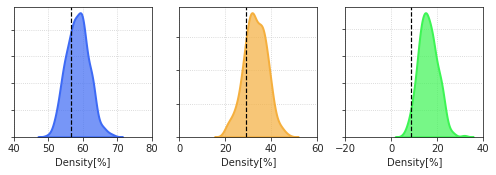

In [68]:
fig, axes = create_figure(2, 3, (7, 4.5))
for i, ax in enumerate(axes.flat):
    try:
        data = output_booted_ca['cut_group'][:, i, -1]
        # data = coutput_booted_ca['cut_group'][:, i, -1]
        mean = bn.nanmean(output_ca['cut_anim'], 0)[i, -1]
    except IndexError:
        continue
    ax.axvline(mean, color='k', ls='--', lw=1.2)
    sns.kdeplot(
        data=data, ax=ax, color=gr.colors[i+1], shade=True,
        alpha=0.7, lw=2.,
    )
    xticks = ax.get_xticks()
    ax.set_xticks([e for e in xticks if int(e) == np.round(e, 1)])
    ax.tick_params(axis='y', labelleft=False)
    ax.set_xlabel('Density[%]')
    ax.set_ylabel('')
    ax.grid()
trim_axs(axes, gr.num_k)
plt.show()

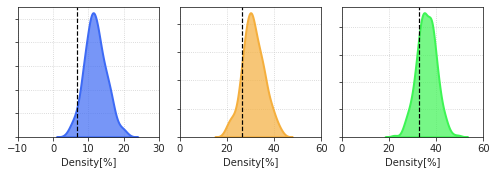

In [69]:
fig, axes = create_figure(2, 3, (7, 4.5))
for i, ax in enumerate(axes.flat):
    try:
        data = output_booted_bold['cut_group'][:, i, -1]
        # data = coutput_booted_bold['cut_group'][:, i, -1]
        mean = bn.nanmean(output_bold['cut_anim'], 0)[i, -1]
    except IndexError:
        continue
    ax.axvline(mean, color='k', ls='--', lw=1.2)
    sns.kdeplot(
        data=data, ax=ax, color=gr.colors[i+1], shade=True,
        alpha=0.7, lw=2.,
    )
    xticks = ax.get_xticks()
    ax.set_xticks([e for e in xticks if int(e) == np.round(e, 1)])
    ax.tick_params(axis='y', labelleft=False)
    ax.set_xlabel('Density[%]')
    ax.set_ylabel('')
    ax.grid()
trim_axs(axes, gr.num_k)
plt.show()

## Memberships on cortex

In [17]:
_disj = gr.get_disjoint_community(output_ca['pi_group'], to_vec=True)
pi_avg_with_disj_ca = np.concatenate([output_ca['pi_group'], np.expand_dims(_disj, 0)])
proj_ca = gr.project_vec(pi_avg_with_disj_ca)

_disj = gr.get_disjoint_community(output_bold['pi_group'], to_vec=True)
pi_avg_with_disj_bold = np.concatenate([output_bold['pi_group'], np.expand_dims(_disj, 0)])
proj_bold = gr.project_vec(pi_avg_with_disj_bold)

In [18]:
fig, _ = gr.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'CA$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"CA$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=18, y=1.02)

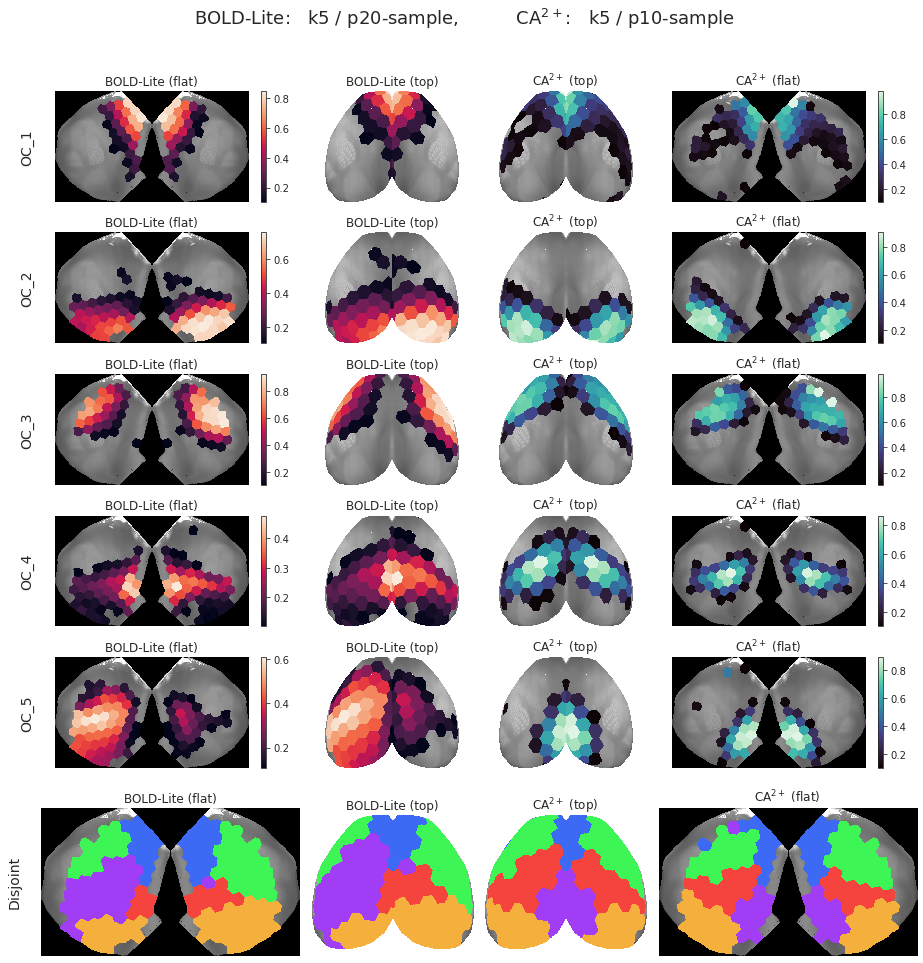

In [19]:
fig

In [66]:
sv_ca = SVINET(key='sub-SLC', mode='ca2', **props_ca).load_results()
sv_bold = SVINET(key='sub-SLC', mode='bold-lite', **props_bold).load_results()

sv_ca.pi.shape, sv_bold.pi.shape

((5, 146), (5, 146))

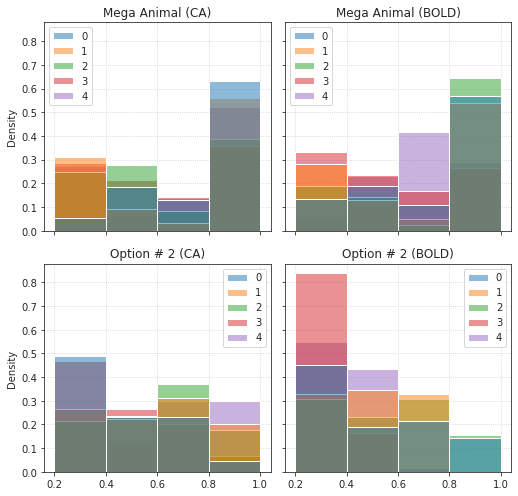

In [70]:
fig, axes = create_figure(2, 2, (7.3, 7), sharex='all', sharey='all')

sns.histplot(sv_ca.pi.T, bins=bins, stat='density', ax=axes[0, 0])
sns.histplot(sv_bold.pi.T, bins=bins, stat='density', ax=axes[0, 1])

sns.histplot(output_ca['pi_group'].T, bins=bins, stat='density', ax=axes[1, 0])
sns.histplot(output_bold['pi_group'].T, bins=bins, stat='density', ax=axes[1, 1])

axes[0, 0].set_title('Mega Animal (CA)')
axes[0, 1].set_title('Mega Animal (BOLD)')
axes[1, 0].set_title('Option # 2 (CA)')
axes[1, 1].set_title('Option # 2 (BOLD)')

for ax in axes.flat:
    ax.grid()

plt.show()

In [71]:
disjoint = gr.get_disjoint_community(sv_ca.pi, to_vec=True)
pi_ca = np.concatenate([sv_ca.pi, np.expand_dims(disjoint, 0)])
proj_ca = gr.project_vec(pi_ca)

disjoint = gr.get_disjoint_community(sv_bold.pi, to_vec=True)
pi_bold = np.concatenate([sv_bold.pi, np.expand_dims(disjoint, 0)])
proj_bold = gr.project_vec(pi_bold)

In [72]:
fig, _ = gr.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'CA$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = 'Mega Animal\n'
sup += f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"CA$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=18, y=1.02)

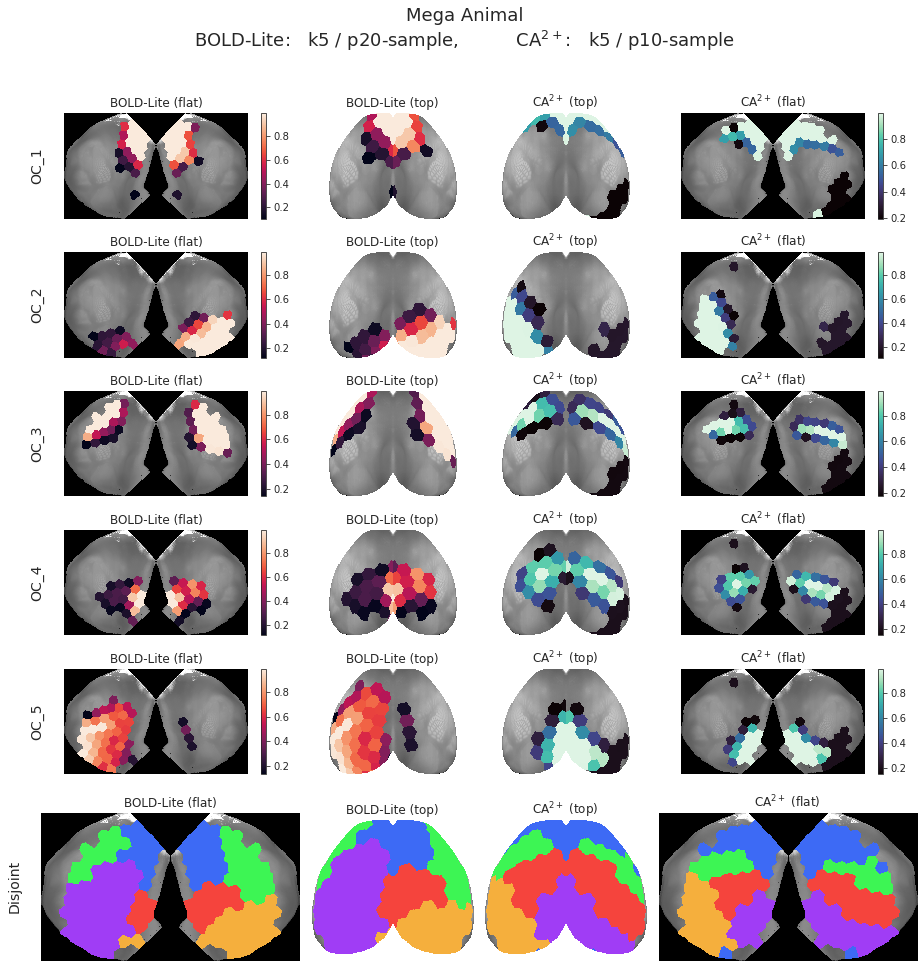

In [73]:
fig

In [77]:
dlist = []
for i in range(gr.num_k):
    for j, intvl in enumerate(gr.intervals):
        dlist.append({
            'interval': [intvl] * len(output_ca['cut_anim']),
            'oc_idx': [i + 1] * len(output_ca['cut_anim']),
            'color': [gr.colors[i + 1]] * len(output_ca['cut_anim']),
            'subject': range(len(output_ca['cut_anim'])),
            'mean': output_ca['cut_anim'][:, i, j],
            'se': [boot_ca['se'][i, j]] * len(output_ca['cut_anim']),
        })
df_ca = pd.DataFrame(merge_dicts(dlist))

In [78]:
df_ca

,interval,oc_idx,color,subject,mean,se
0,"(0.2, 0.4]",1,#3d6af5,0,50.000000,2.925415
1,"(0.2, 0.4]",1,#3d6af5,1,31.818182,2.925415
2,"(0.2, 0.4]",1,#3d6af5,2,41.025641,2.925415
3,"(0.2, 0.4]",1,#3d6af5,3,49.056604,2.925415
4,"(0.2, 0.4]",1,#3d6af5,4,38.297872,2.925415
...,...,...,...,...,...,...
195,"(0.8, 1.0]",5,#a03df5,5,57.575758,5.868328
196,"(0.8, 1.0]",5,#a03df5,6,57.575758,5.868328
197,"(0.8, 1.0]",5,#a03df5,7,48.484848,5.868328
198,"(0.8, 1.0]",5,#a03df5,8,25.714286,5.868328


In [132]:
figs, sups, axes, axes_inset = plot_group(
    df_real=df_ca,
    inset_kind='kde',
    inset_data=output_booted_ca['cut_group'][..., -1].T,
    save_file=pjoin(tmp_dir, f"Fig-1_CA2_{now()}.pdf"),
)

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/Fig-1_CA2_(2021_11_17).pdf

done.

In [135]:
dlist = []
for i in range(gr.num_k):
    for j, intvl in enumerate(gr.intervals):
        dlist.append({
            'interval': [intvl] * len(output_bold['cut_anim']),
            'oc_idx': [i + 1] * len(output_bold['cut_anim']),
            'color': [gr.colors[i + 1]] * len(output_bold['cut_anim']),
            'subject': range(len(output_bold['cut_anim'])),
            'mean': output_bold['cut_anim'][:, i, j],
            'se': [boot_bold['se'][i, j]] * len(output_bold['cut_anim']),
        })
df_bold = pd.DataFrame(merge_dicts(dlist))

In [137]:
figs, sups, axes, axes_inset = plot_group(
    df_real=df_bold,
    inset_kind='kde',
    inset_data=output_booted_bold['cut_group'][..., -1].T,
    save_file=pjoin(tmp_dir, f"Fig-1_BOLD_{now()}.pdf"),
)

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/Fig-1_BOLD_(2021_11_17).pdf

done.